In [1]:
import torch
import torch.nn as nn
import os
# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'ch3_32_interval_3_240'
unet_model = torch.load(os.path.join('models', model_name,f"{model_name}.pth"))
# model = _model.to(device)
# model = nn.DataParallel(model).to(device)
unet_model.eval()

model_name = 'ppl_sm_d52_w128_b4_e50'
pp_model = torch.load(os.path.join('models', model_name,f"{model_name}.pth"))
pp_model.eval()

DataParallel(
  (module): UNETPP(
    (up_op): Upsample(scale_factor=(1.0, 2.0, 2.0), mode='trilinear')
    (stem): double_conv(
      (dconv): Sequential(
        (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(1, 16, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(1, 16, eps=1e-05, affine=True)
        (5): ReLU(inplace=True)
      )
    )
    (encoder): ModuleList(
      (0): down_op(
        (down): Sequential(
          (0): MaxPool3d(kernel_size=3, stride=(1, 2, 2), padding=1, dilation=1, ceil_mode=False)
          (1): double_conv(
            (dconv): Sequential(
              (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): GroupNorm(1, 32, eps=1e-05, affine=True)
              (2): ReLU(inplace=True)
              (3): Conv3d(32, 32, kernel_size=(3, 3, 3), 

In [2]:
from utils import get_dataloader
from dataset import BratsDataset

test_dataloader = get_dataloader(dataset=BratsDataset, phase="train", img_depth=155, img_width=128, data_type=[
      "-t1n.nii.gz",
      "-t1c.nii.gz",
      # "-t2w.nii.gz",
      "-t2f.nii.gz"
    ], batch_size=1)

In [3]:
from utils import DiceLoss
from torch.nn import BCEWithLogitsLoss

dice_loss = DiceLoss()
bce_loss = BCEWithLogitsLoss()

In [4]:
with torch.no_grad():
    tb = next(iter(test_dataloader))
    ids, imgs, targets = tb['Id'], tb['image'], tb['mask']
    imgs = imgs.to(device)
    targets = targets.to(device)
    print(imgs.shape, targets.shape)
    unet_logits = unet_model(imgs)
    pp_logits = pp_model(imgs)
    
    unet_dice = dice_loss(unet_logits, targets)
    unet_bce = bce_loss(unet_logits, targets)

    pp_dice = dice_loss(pp_logits, targets)
    pp_bce = bce_loss(pp_logits, targets)
    print(unet_dice, unet_bce, pp_dice, pp_bce)

torch.Size([1, 3, 52, 128, 128]) torch.Size([1, 3, 52, 128, 128])
tensor(0.3314, device='cuda:0') tensor(0.0245, device='cuda:0') tensor(0.3752, device='cuda:0') tensor(0.0131, device='cuda:0')


In [5]:
img_cpu = imgs[0].detach().cpu().numpy()
target_cpu = targets[0].detach().cpu().numpy()
img_cpu.shape, target_cpu.shape

((3, 52, 128, 128), (3, 52, 128, 128))

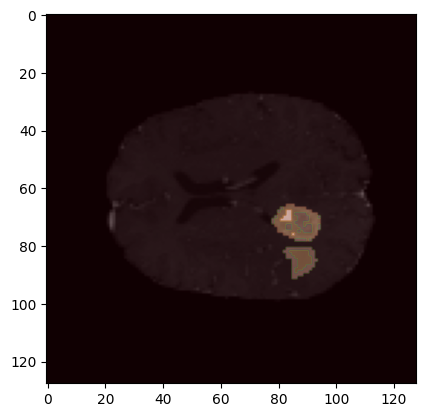

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img_cpu[1][28], cmap='gray')
plt.imshow(target_cpu[0][28], cmap='copper', alpha=0.5)
plt.imshow(target_cpu[1][28], cmap='gist_rainbow', alpha=0.1)
plt.imshow(target_cpu[2][28], cmap='gist_heat', alpha=0.3)

In [12]:
import numpy as np
np.unique(target_cpu, return_counts=True)

(array([0., 1.], dtype=float32), array([2547748,    8156]))